In [1]:
# http://www.robesafe.uah.es/personal/eduardo.romera/uah-driveset/

# http://www.robesafe.uah.es/personal/eduardo.romera/pdfs/Romera16itsc.pdf
# pdf contains description of data (what each column means)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import os
import folium
from geopy.distance import distance
import datetime

from ride_parser import UAHRideParser, RealRideParser
from app_data_parser import get_data_from_app
from PIL import Image

import matplotlib.dates as mdates

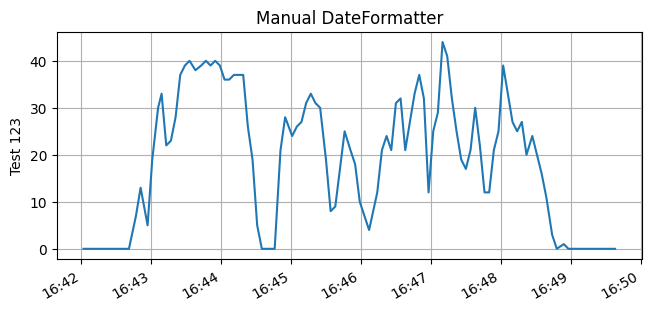

                    timestamp  SPEED
0   2023-11-03 13:42:02-03:00    0.0
1   2023-11-03 13:42:07-03:00    0.0
2   2023-11-03 13:42:11-03:00    0.0
3   2023-11-03 13:42:15-03:00    0.0
4   2023-11-03 13:42:19-03:00    0.0
..                        ...    ...
102 2023-11-03 13:49:19-03:00    0.0
103 2023-11-03 13:49:24-03:00    0.0
104 2023-11-03 13:49:28-03:00    0.0
105 2023-11-03 13:49:35-03:00    0.0
106 2023-11-03 13:49:38-03:00    0.0

[107 rows x 2 columns]


In [8]:
app_data = get_data_from_app()

velocities = app_data["SPEED"]

fig, axs = plt.subplots(1, 1, figsize=(6.4, 3), layout='constrained')
# common to all three:
# for ax in axs:

# ax.plot('date', 'adj_close', data=data)
plt.plot("timestamp", "SPEED", data=velocities)
# Major ticks every half year, minor ticks every second,
axs.xaxis.set_major_locator(mdates.MinuteLocator())
axs.xaxis.set_minor_locator(mdates.MinuteLocator())
axs.grid(True)
axs.set_ylabel("Velocidade")
axs.set_xlabel("Horário")

# ax = axs[0]
first_timestamp = velocities.iloc[0]["timestamp"]
record_day_month_year_string = first_timestamp.strftime("%d/%m/%Y")
axs.set_title("Captura " + record_day_month_year_string)

axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in axs.get_xticklabels(which='major'):
	label.set(rotation=30, horizontalalignment='right')

plt.show()

print(app_data["SPEED"])

In [2]:
ride_root_dir = os.path.join("RealData")

real_ride = RealRideParser(ride_root_dir)

# real_ride.gps_df.dtypes
# ride.gps_df
# ride.accelerometer_df

real_ride.get_acc_stats()

count    396.000000
mean       9.761073
std        0.700837
min        6.076800
25%        9.500167
50%        9.708756
75%       10.047497
max       14.253094
Name: acc_resultant, dtype: float64

In [3]:
latitudes = real_ride.gps_df["lat"]
longitudes = real_ride.gps_df["long"]

qtty_data = len(latitudes)

lat_longs = [(latitudes.iloc[i], longitudes.iloc[i]) for i in range(qtty_data)]

real_ride.accelerometer_df

,timestamp,acc_x,acc_y,acc_z,filtered_acc_x,filtered_acc_y,filtered_acc_z,acc_resultant
0,1.699029e+09,0.36,6.04,7.54,0.36,6.04,7.54,9.667616
1,1.699029e+09,0.34,5.97,7.65,0.34,5.97,7.65,9.709737
2,1.699029e+09,0.38,6.14,7.58,0.38,6.14,7.58,9.762192
3,1.699029e+09,-0.15,6.34,7.55,-0.15,6.34,7.55,9.860051
4,1.699029e+09,-0.13,6.07,8.02,-0.13,6.07,8.02,10.058936
...,...,...,...,...,...,...,...,...
391,1.699030e+09,0.49,5.33,8.07,0.49,5.33,8.07,9.683692
392,1.699030e+09,0.47,5.27,8.01,0.47,5.27,8.01,9.599682
393,1.699030e+09,0.46,5.28,8.02,0.46,5.28,8.02,9.613033
394,1.699030e+09,0.48,5.28,8.07,0.48,5.28,8.07,9.655760


In [4]:
start_lat_long = lat_longs[0]
end_lat_long = lat_longs[-1]

mean_lat = latitudes.mean()
mean_long = longitudes.mean()

start_lat_long, end_lat_long, qtty_data

((-23.5523206, -46.6656069), (-23.5523127, -46.6656244), 192)

In [5]:
map = folium.Map(location=[mean_lat, mean_long], zoom_start=14, control_scale=True)

folium.Marker(start_lat_long, popup="start").add_to(map)
folium.Marker(end_lat_long, popup="end").add_to(map)

In [6]:
for i in range(qtty_data - 1):
	location_1 = lat_longs[i]
	location_2 = lat_longs[i + 1]

	folium.PolyLine([location_1, location_2],
					color='red',
					weight=5,
					opacity=0.4).add_to(map)

map

In [7]:
accelerometer_df = real_ride.accelerometer_df
oldest_timestamp = int(accelerometer_df.timestamp.iloc[-1])
delta_time_size = 100 	# 100 s
frame_granularity = 10 	# 50 s
qtty_frames = (oldest_timestamp - delta_time_size) // frame_granularity

filtered_accelerations_df = accelerometer_df

print("oldest_timestamp", oldest_timestamp)
print("qtty_frames", qtty_frames)
print("oldest_timestamp", oldest_timestamp)

qtty_frames = min(qtty_frames, 100)

# foo_for_real_data(accelerometer_df, frame_granularity, delta_time_size, 0)

for i in range(10): #qtty_frames):
    real_ride.foo_for_real_data(frame_granularity, delta_time_size, i)


oldest_timestamp 1699030179
qtty_frames 169903007
oldest_timestamp 1699030179


Objetivos:
- [] Gerar mapa com a rota feita por cada um dos motoristas
- [] Sincronizar vídeo com eventos de aceleração

In [8]:
# ride_root_dir = os.path.join("UAH-DRIVESET-v1", "D1", "20151110175712-16km-D1-NORMAL1-SECONDARY")
ride_root_dir = os.path.join("UAH-DRIVESET-v1", "D1", "20151111125233-24km-D1-AGGRESSIVE-MOTORWAY")

ride = UAHRideParser(ride_root_dir)

# col_names = [str(i) for i in range(13)]
# col_names = ["timestamp", "speed", "lat", "long", "altitude", "vert accuracy", "horiz accuracy", "course", "difcourse", "?1", "?2", "?3", "?4"]
# pd.read_csv(gps_file_path, sep=" ", names=col_names)

ride.gps_df
ride.accelerometer_df

,timestamp,is speed gt 50 kmh,acc_x,acc_y,acc_z,filtered_acc_x,filtered_acc_y,filtered_acc_z,roll_degrees,pitch_degrees,yaw_degrees,?1,?2,?3,?4,acc_resultant
0,8.02,1,-0.013,-0.021,0.011,-0.031,-0.009,0.013,-1.627,-0.011,0.294,NaN,NaN,NaN,NaN,0.027037
1,8.12,1,-0.008,-0.005,-0.017,-0.018,-0.011,0.002,-1.626,-0.007,0.297,NaN,NaN,NaN,NaN,0.019442
2,8.22,1,-0.013,-0.026,-0.012,-0.005,-0.011,-0.008,-1.625,-0.003,0.299,NaN,NaN,NaN,NaN,0.031448
3,8.32,1,-0.049,-0.018,0.033,-0.029,-0.018,0.002,-1.626,0.001,0.302,NaN,NaN,NaN,NaN,0.061758
4,8.43,1,0.016,0.009,0.014,-0.021,-0.008,0.021,-1.627,0.004,0.304,NaN,NaN,NaN,NaN,0.023087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282,745.45,1,0.004,-0.009,0.019,-0.003,-0.017,0.009,-1.527,0.010,-2.639,NaN,NaN,NaN,NaN,0.021401
7283,745.55,1,-0.013,-0.019,-0.049,0.004,-0.033,-0.005,-1.525,0.015,-2.636,NaN,NaN,NaN,NaN,0.054139
7284,745.65,1,-0.082,-0.012,0.001,-0.043,-0.007,-0.024,-1.526,0.014,-2.637,NaN,NaN,NaN,NaN,0.082879
7285,745.75,1,-0.041,-0.037,0.025,-0.052,-0.021,0.010,-1.528,0.014,-2.632,NaN,NaN,NaN,NaN,0.060622


In [9]:
accelerometer_df = ride.accelerometer_df
oldest_timestamp = int(accelerometer_df.timestamp.iloc[-1])
delta_time_size = 20
frame_granularity = 1
qtty_frames = (oldest_timestamp - delta_time_size) // frame_granularity

print("qtty_frames", qtty_frames)
print("oldest_timestamp", oldest_timestamp)

for i in range(10): #qtty_frames):
    with ProcessPoolExecutor(max_workers=10) as executor:
        future = executor.submit(ride.foo, accelerometer_df, frame_granularity, delta_time_size, i)

    # print(future.result())

# plt.show()
# RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

qtty_frames 725
oldest_timestamp 745


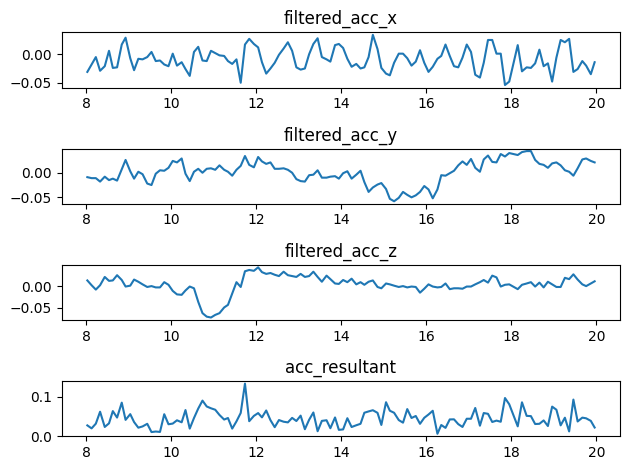

In [10]:
fig, axs = plt.subplots(ncols=1, nrows=4)

accelerometer_df = ride.accelerometer_df
accelerometer_df = accelerometer_df[accelerometer_df.timestamp < 20]
filtered_acc_x = accelerometer_df["filtered_acc_x"]
filtered_acc_y = accelerometer_df["filtered_acc_y"]
filtered_acc_z = accelerometer_df["filtered_acc_z"]
acc_resultant = accelerometer_df["acc_resultant"]
timestamp = accelerometer_df["timestamp"]

# axs[0].scatter(timestamp, filtered_acc_x, s=0.1)
axs[0].plot(timestamp, filtered_acc_x) #, "-o")
axs[0].set_title("filtered_acc_x")

axs[1].plot(timestamp, filtered_acc_y)
axs[1].set_title("filtered_acc_y")

axs[2].plot(timestamp, filtered_acc_z)
axs[2].set_title("filtered_acc_z")

axs[3].plot(timestamp, acc_resultant)
axs[3].set_title("acc_resultant")

fig.tight_layout()

plt.show()

TypeError: get_data_from_app.<locals>.<lambda>() got an unexpected keyword argument 'inplace'

In [12]:
imgs = ride.generate_acc_sub_graph()

# im = Image.open(next(imgs))
# im.show(title="My Image")

In [13]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.animation as animation

# import numpy
# from PIL import Image

# n = 20

# img = [] # some array of images
# for i in range(n):
# 	imarray = numpy.random.rand(100,100,3) * 255
# 	im = Image.fromarray(imarray.astype('uint8')).convert('RGBA')
# 	img.append(im)

# frames = [] # for storing the generated images
# fig = plt.figure()
# for i in range(n):
# 	frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

# ani = animation.ArtistAnimation(fig, frames, blit=True)

# writergif = animation.PillowWriter(fps=1)
# ani.save('movie.gif', writer=writergif)
# plt.show()

In [14]:
# import io
# from PIL import Image
# import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

# plt.figure()
# plt.plot([1, 2])

# img_buf = io.BytesIO()
# plt.savefig(img_buf, format='png')

# im = Image.open(img_buf)
# im.show(title="My Image")

# img_buf.close()